In [2]:
from flightanalysis import Section, get_schedule, FCJson

with open("/home/tom/Documents/AutoJudge/fc_jsons/manual_F3A_P23_21_10_23_00000117.json", "r") as f:
    fcj = FCJson.parse_fc_json(f)

/home/tom/miniconda3/envs/pyflightcoach/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/tom/miniconda3/envs/pyflightcoach/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
import numpy as np
import pandas as pd
from scipy import integrate
import plotly.express as px

fcj_aligned = fcj.schedule.get_subset(fcj.sec, 0, 17)
sec = fcj_aligned.remove_labels()

sched = get_schedule(fcj.schedule.category, fcj.schedule.name)

distance = sec.y.mean()
speed = sec.bvx.mean()
print("distance = {}, speed = {}".format(distance,1.2* speed))
template = sched.scale_distance(distance).create_raw_template(sec[0].direction, speed, distance)



distance = 212.21233999758022, speed = 31.553296819362746


In [15]:
def get_brv(section):
    brv = np.gradient(section.data.index)  * section.gbrvel
    brv.data[:,0] = abs(brv.data[:,0])
    brv.data[:,2] = abs(brv.data[:,2]) * 0.1
    return brv



In [16]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from geometry import Points, Point

def get_brv(sec):
    brv = sec.gbrvel
    brv.data[:,0] = abs(brv.data[:,0])
    brv.data[:,2] = abs(brv.data[:,2])
    return brv


def align(tp, fl):
    return fastdtw(
        tp.data,
        fl.data,
        radius=3,
        dist=euclidean
    )


brvfl = get_brv(sec)
brvtp = get_brv(template)

norms = max(brvfl.abs().max(), brvtp.abs().max())
brvflnorm = brvfl * (Point(1, 1, 0.1) / norms)
brvtpnorm = brvtp * (Point(1, 1, 0.1) / norms) 

#
dist, path = align(brvflnorm, brvtpnorm)



In [17]:
def copy_labels(template, flown, path):
    mans = pd.DataFrame(path, columns=["template", "flight"]).set_index("template").join(
            template.data.reset_index().loc[:, ["manoeuvre", "element"]]
        ).groupby(['flight']).last().reset_index().set_index("flight")

    return Section(flown.data.reset_index().join(mans).set_index("time_index"))

align_vals = copy_labels(template, sec, path)


In [18]:
from flightplotting.plots import plotdtw, plotsec


plotdtw(align_vals, sched.manoeuvres)#[0].elements)

no data for manoeuvre hsq2, Section created with empty dataframe
no data for manoeuvre figM, Section created with empty dataframe
no data for manoeuvre fight, Section created with empty dataframe
no data for manoeuvre tri, Section created with empty dataframe
no data for manoeuvre shark, Section created with empty dataframe
no data for manoeuvre loop, Section created with empty dataframe
no data for manoeuvre Landing, Section created with empty dataframe


In [3]:

from scipy import signal


brv = sched.manoeuvres[0].get_data(align_vals).brvel


fs=30
fc = 5  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')
filtered = signal.filtfilt(b, a, brv.brvr)

#filtered = signal.sosfilt(signal.butter(4, 100, 'low', analog=True), brv.brvr)



#px.line(sched.manoeuvres[0].get_data(align_vals).brvel).show()
#rbrv = brv.rolling(5).sum()
#rbrv
#px.line(filtered[::2]).show()
px.line(brv.loc[::10]).show()
px.line(brv).show()

NameError: name 'sched' is not defined

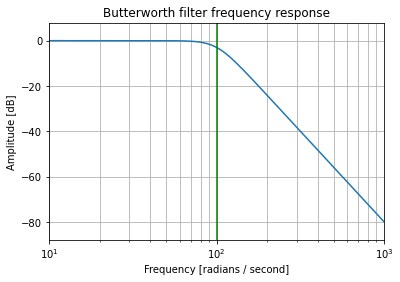

In [54]:
from scipy import signal
import matplotlib.pyplot as plt
b, a = signal.butter(4, 100, 'low', analog=True)
w, h = signal.freqs(b, a)

plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()